In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Segmentação (imagem Binária) da faixa Verde
tomClaro_G = np.array([40, 100, 100])
tomEscuro_G = np.array([80, 255, 255])
# Segmentação (imagem Binária) da faixa Azul
tomClaro_B = np.array([100, 100, 100])
tomEscuro_B = np.array([140, 255, 255])
# Segmentação (imagem Binária) da faixa Vermelha
tomClaro_R = np.array([160, 100, 100])
tomEscuro_R = np.array([200, 255, 255])

In [3]:
def processaImagem(img, cor):
    # Obtencao das dimensoes da imagem
    altura = np.size(img,0)
    largura= np.size(img,1)

    # Conversão para formato HSV (melhor para segmentação por cor)
    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Imagem Segmentada (Máscara Binária)
    if (cor == "verde"):
        tomClaro = tomClaro_G
        tomEscuro = tomEscuro_G
    elif (cor == "azul"):
        tomClaro = tomClaro_B
        tomEscuro = tomEscuro_B
    elif (cor == "vermelho"):
        tomClaro = tomClaro_R
        tomEscuro = tomEscuro_R

    # Segmenta a Imagem
    imgSegmentadaComRuido = cv2.inRange(imgHSV, tomClaro, tomEscuro)

    # Elemento Estruturante (Kernel 3x3)
    kernel = np.ones((3, 3), np.uint8)

    # Fechamento (cv2.MORPH_CLOSE) - Dilatação seguida por Erosão
    # Objetivo: Fechar pequenos buracos dentro da faixa
    imgSegmentada = cv2.morphologyEx(imgSegmentadaComRuido, cv2.MORPH_CLOSE, kernel)

    # Abertura (cv2.MORPH_OPEN) - Erosão seguida por Dilatação
    # Objetivo: Remover pequenos pontos isolados fora da faixa principal
    imgSegmentada = cv2.morphologyEx(imgSegmentada, cv2.MORPH_OPEN, kernel)

    # Prepara a imagem original para exibição (OpenCV lê BGR, Matplotlib espera RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Preparação para exibição da imagem segmentada com ruído em cores originais ---
    # Aplica a máscara imgSegmentadaComRuido à imagem original para mostrar as cores originais apenas na área segmentada
    imgSegmentadaComRuido_colored = cv2.bitwise_and(img_rgb, img_rgb, mask=imgSegmentadaComRuido)

    # --- Preparação para exibição da imagem com todos os desenhos em cores originais ---
    # Cria uma cópia da imagem original colorida para desenhar
    image_with_all_drawings = img_rgb.copy()

    # Desenhando retângulo
    # Encontra contornos na imgSegmentada
    contours, _ = cv2.findContours(imgSegmentada.copy(),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    x, y, w, h = 0, 0, 0, 0 # Initialize bounding box coordinates
    if contours:
        # Encontra o maior contorno
        largest_contour = max(contours, key=cv2.contourArea)

        # Obtém o retângulo delimitador para o maior contorno
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Desenha o retângulo na imagem colorida
        cv2.rectangle(image_with_all_drawings, (x, y), (x + w, y + h), (255, 222, 33), 4) # Cor amarela (BGR)
    else:
        print("Nenhuma faixa foi identificada para desenhar o retângulo.")

    # Desenhando linha central
    cv2.line(
        image_with_all_drawings,
        (int(largura // 2), 0),
        (int(largura // 2), int(altura)),
        (160, 32, 240), # Cor Roxo (BGR)
        2
    )

    # Desenhando Centroide
    cX, cY = 0, 0 # Inicializa as coordenadas do centroide
    if 'largest_contour' in locals() and largest_contour is not None:
        M = cv2.moments(largest_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

    cv2.circle(image_with_all_drawings, (cX, cY), 5, (255, 222, 33), 4) # Cor amarela (BGR)

    # Distância linha de referência/Centroide
    distance = abs(cX - (largura // 2))
    cv2.line(image_with_all_drawings, (cX, cY), ((largura // 2), cY), (0, 255, 255), 2) # Cor amarela (BGR)

    text_x = min(cX, (largura // 2)) + abs(cX - (largura // 2)) // 2
    text_y = cY - 10 if cY > 20 else cY + 20

    cv2.putText(image_with_all_drawings, f"Dist: {distance} pixels", (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA) # Cor preta (BGR)

    # Cria uma figura para mostrar a comparação
    plt.figure(figsize=(18, 5))

    # Posição 1: Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("1. Original (RGB)")

    # Posição 2: Segmentação com Cores Originais
    plt.subplot(1, 3, 2)
    plt.imshow(imgSegmentadaComRuido_colored)
    plt.title(f"2. Segmentada {cor} (Com Cores Originais e Ruído)")

    # Posição 3: Após Limpeza Morfológica com Desenhos e Cores Originais
    plt.subplot(1, 3, 3)
    plt.imshow(image_with_all_drawings)
    plt.title("3. Após Limpeza Morfológica com Desenhos (Cores Originais)")

    plt.tight_layout()
    plt.show()

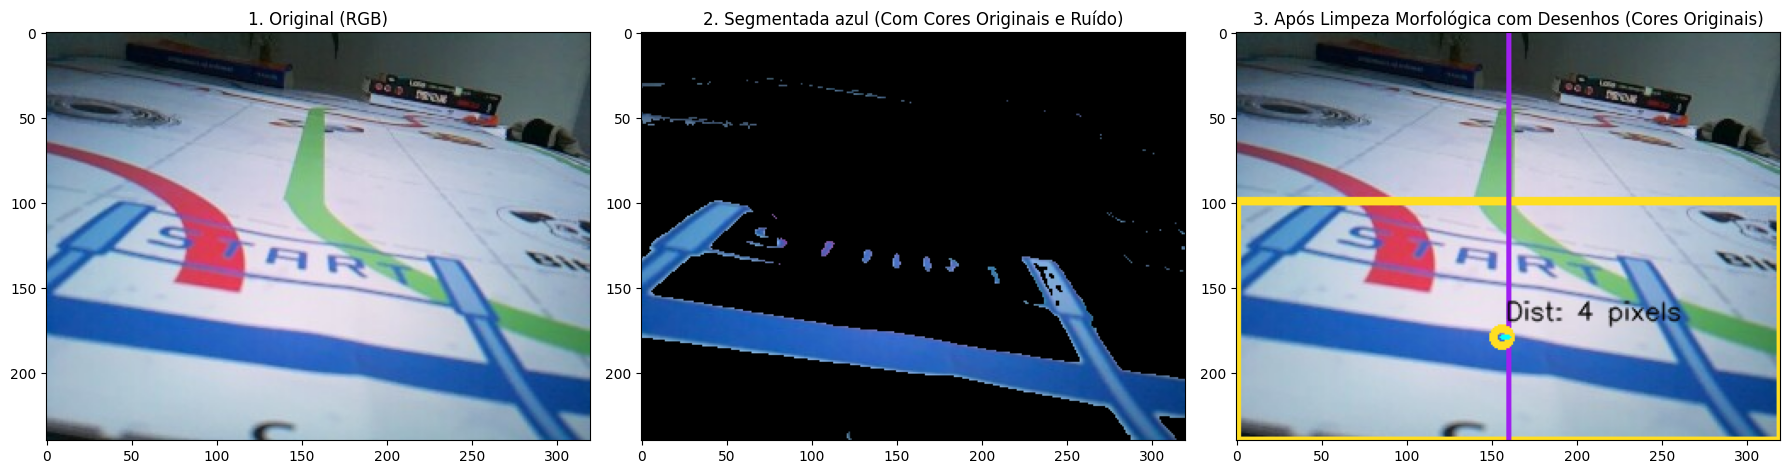

In [8]:
# Leitura da imagem original
imgRGB = cv2.imread("dataset/missao/image_20251115-150933.jpg")
#imgRGB = cv2.imread("dataset/missao/image_20251115-152754.jpg")
#imgRGB = cv2.imread("dataset/missao/image_20251115-152657.jpg")
#imgRGB = cv2.imread("dataset/missao/image_20251115-153248.jpg")

# Cor: "vermelho" | "verde" | "azul"
processaImagem(imgRGB, "azul")